## Calculate attributes
Takes prepared geospatial data and computes various attributes.

In [1]:
import pandas as pd
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
from python_cs_functions import config as cs, attributes as csa
from python_cs_functions.delineate import prepare_delineation_outputs

/var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/ipykernel_69745/3056185177.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path            = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')
basins_path = Path(data_path) / cs_basin_folder

# Get the temporary data folder
cs_temp_folder = cs.read_from_config(config_file, 'temp_path')
temp_path = Path(cs_temp_folder)
temp_path.mkdir(exist_ok=True, parents=True)

### Data loading

In [4]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [5]:
# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object})

### Processing

In [6]:
debug_message = f'\n!!! CHECK DEBUGGING STATUS: \n- Testing 1 file \n- Testing 1 basin'

In [7]:
geo_subfolders = ['era5', 'worldclim', 'forest_height', 'lai']
# 'glclu2019', 'glhymps', 'hydrolakes','lgrip30','merit','modis_land','pelletier','soilgrids', 

In [8]:
# Every attribute needs a list, so that we can efficiently construct a dataframe later
l_gauges = [] # station ID

In [9]:
print(debug_message)
for ix,row in cs_meta.iterrows():

    # DEBUGGING
    if ix != 0: continue

    # Get the paths
    basin_id, shp_lump_path, shp_dist_path, _, _ = prepare_delineation_outputs(cs_meta, ix, basins_path)
    geo_folder = basins_path / 'basin_data' / basin_id / 'geospatial'
    met_folder = basins_path / 'basin_data' / basin_id / 'forcing'

    # Data storage
    l_gauges.append(basin_id) # Update the Station list
    l_values = [] # Initialize an empty list where we'll store this basin's attributes
    l_index = [] # Initialize an empty list where we'll store the attribute descriptions

    # Load the shapefile
    #shp = gpd.read_file(shp_lump_path)
    #shp_dist = gpd.read_file( Path(str(shp_dist_path).format('basin')) )
    shp = str(shp_lump_path) # because zonalstats wants a file path, not a geodataframe
    
    # Data-specific processing
    print(f'Processing geospatial data into attributes for {basin_id}')
    for dataset in geo_subfolders:
        print(f' - processing {dataset}')

        ## CLIMATE
        if dataset == 'era5':
            l_values, l_index = csa.attributes_from_era5(met_folder, shp, 'era5', l_values, l_index)                                
        if dataset == 'worldclim':
            csa.oudin_pet_from_worldclim(geo_folder, dataset) # Get an extra PET estimate to sanity check ERA5 outcomes
            cas.aridity_and_fraction_snow_from_worldclim(geo_folder, dataset) # Get monthly aridity and fraction snow maps
            l_values, l_index = csa.attributes_from_worldclim(geo_folder, dataset, shp, l_values, l_index)

        ## VEGETATION
        if dataset == 'forest_height':
            l_values, l_index = csa.attributes_from_forest_height(geo_folder, dataset, shp, l_values, l_index)
        if dataset == 'lai':
            l_values, l_index = csa.attributes_from_lai(geo_folder, dataset, temp_path, shp, l_values, l_index)
        

        ## LAND COVER
        # root depth from IGBP, ala A

print(debug_message)


!!! CHECK DEBUGGING STATUS: 
- Testing 1 file 
- Testing 1 basin
Processing geospatial data into attributes for CAN_01AD002
 - processing era5
checking 1949-12-31 19:00:00
checking 1950-12-31 19:00:00
 - processing worldclim


/Users/wmk934/data/CAMELS_spat/camels-spat-env/lib/python3.11/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


 - processing forest_height
 - processing lai

!!! CHECK DEBUGGING STATUS: 
- Testing 1 file 
- Testing 1 basin


In [12]:
len(l_values),len(l_index)

(392, 392)

#### Make the dataframe

In [10]:
# Test with a fake second station
l_gauges = ['CAN_01AD002','CAN_01AD003']

# Make the dataframe
input_dict = dict(zip(l_gauges, [l_values,l_values]))
df = pd.DataFrame(input_dict)

# Set the index
multi_index = pd.MultiIndex.from_tuples(l_index, names=['Category', 'Attribute', 'Unit', 'Source'])
df.index = multi_index

# Drop the fake extra column
df = df.drop(columns=['CAN_01AD003'], axis=1)

df

CAN_01AD002
Category   Attribute          Unit     Source                  
Climate    pet_mean_month_01  mm       ERA5            5.603236
           pet_mean_month_02  mm       ERA5            6.938123
           pet_mean_month_03  mm       ERA5           11.453971
           pet_mean_month_04  mm       ERA5           17.082488
           pet_mean_month_05  mm       ERA5           29.253726
...                                                         ...
Vegetation lai_stdev_month_10 m^2 m^-2 MCD15A2H.061    0.433981
           lai_mean_month_11  m^2 m^-2 MCD15A2H.061     0.80269
           lai_stdev_month_11 m^2 m^-2 MCD15A2H.061    0.350392
           lai_mean_month_12  m^2 m^-2 MCD15A2H.061    1.019866
           lai_stdev_month_12 m^2 m^-2 MCD15A2H.061    0.591287

[392 rows x 1 columns]

In [26]:
# Example of selection code
tmp = df.loc[df.index.get_level_values('Attribute').str.contains('srad') & 
             df.index.get_level_values('Attribute').str.contains('mean')].copy()
tmp

CAN_01AD002
Category Attribute          Unit         Source                 
Climate  srad_mean_month_01 kJ m^-2 d^-1 WorldClim   5172.237573
         srad_mean_month_02 kJ m^-2 d^-1 WorldClim    8355.55742
         srad_mean_month_03 kJ m^-2 d^-1 WorldClim  12271.464971
         srad_mean_month_04 kJ m^-2 d^-1 WorldClim  16016.437573
         srad_mean_month_05 kJ m^-2 d^-1 WorldClim  18453.462728
         srad_mean_month_06 kJ m^-2 d^-1 WorldClim  20250.884038
         srad_mean_month_07 kJ m^-2 d^-1 WorldClim  19587.409774
         srad_mean_month_08 kJ m^-2 d^-1 WorldClim  17251.345243
         srad_mean_month_09 kJ m^-2 d^-1 WorldClim   12647.26453
         srad_mean_month_10 kJ m^-2 d^-1 WorldClim   7845.831604
         srad_mean_month_11 kJ m^-2 d^-1 WorldClim    4692.89285
         srad_mean_month_12 kJ m^-2 d^-1 WorldClim   3979.811015

In [10]:
len(l_values),len(l_index)

(392, 392)

## DEV

In [29]:
ds, l_values, l_index = attributes_from_era5(met_folder, shp, 'era5', l_values, l_index) 

checking 1949-12-31 19:00:00
checking 1950-12-31 19:00:00


In [53]:
ds['snow'] = xr.where(ds['t'] < 273.15, ds['mtpr'],0)

In [85]:
(ds['snow'].resample(time='1ME').mean() / ds['mtpr'].resample(time='1ME').mean()).groupby('time.month').std()

<xarray.DataArray (month: 12, hru: 1)>
array([[1.5853895e-01],
       [1.4884846e-01],
       [1.7997502e-01],
       [1.6395268e-01],
       [3.0566890e-02],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [7.6048984e-08],
       [9.4179943e-02],
       [1.8889844e-01],
       [1.5989324e-01]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: hru

In [73]:
(ds['snow'].groupby('time.month').sum(dim='time') / ds['mtpr'].groupby('time.month').sum(dim='time'))

<xarray.DataArray (month: 12, hru: 1)>
array([[7.8883821e-01],
       [8.5298926e-01],
       [6.7340702e-01],
       [2.7564764e-01],
       [1.2527393e-02],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [9.9461213e-09],
       [4.7229931e-02],
       [3.7943655e-01],
       [7.3117822e-01]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: hru

In [72]:
ds['snow'].sum(dim='time') / ds['mtpr'].sum(dim='time')

<xarray.DataArray (hru: 1)>
array([0.27586064], dtype=float32)
Dimensions without coordinates: hru

In [ ]:
ds['snow']

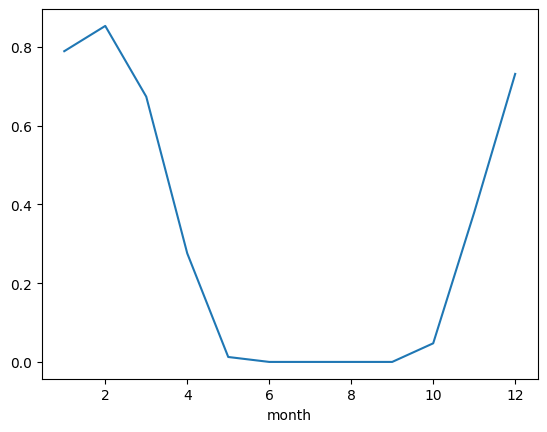

In [62]:
(ds['snow'].groupby('time.month').mean(dim='time') / ds['mtpr'].groupby('time.month').mean(dim='time')).plot()

#### High-level collection functions

In [28]:
import glob
import numpy as np
import xarray as xr
from scipy.stats import circmean, skew, kurtosis

# Define a custom function to apply circmean to each group
# Without this, xarray chokes on dimensions when converting the circmean output back into something with the right month indices
def circmean_group(group):
    return xr.DataArray(circmean(group, high=360, low=0), name='phi')

# Processing function to update the two main lists we're populating
def process_era5_means_to_lists(da, l_values, l_index, var, unit):
    '''Takes an xarray data array with monthly means and processes into l_values and l_index lists'''
    for month in range(1,13):
        val = da.sel(month=month).values.flatten()[0]
        txt = (f'Climate', f'{var}_mean_month_{month:02}', f'{unit}', 'ERA5')
        l_values += [val] # Needs to be this way because we're appending to a list
        l_index  += [txt]
    return l_values, l_index

# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'djf'
    elif month in [3, 4, 5]:
        return 'mam'
    elif month in [6, 7, 8]:
        return 'jja'
    elif month in [9, 10, 11]:
        return 'son'

# Finds duration counts in a vector of True/False values
def find_durations(condition):
    '''Counts the duration(s) of True values in an xarray dataseries'''

    previous = False
    duration = 0
    durations = []
    for flag in condition.values:
        
        # Time step where we reset the count
        if not previous and flag:
            duration = 0 # New first timestep where condition = True, so duration = 0
            previous = True
    
        # Time step where we're in a sequence of condition = True
        if previous and flag:
            duration += 1 # Update duration, implicitly retain previous = True by not changing it
        
        # Time step where we reach the end of a condition = True duration
        if previous and not flag:
            durations.append(duration) # Save the maximum duration length to list
            previous = False # Update previous; duration will be reset next time we encounter a condition = True
    
        # Time step where we're in a continuation of condition = False
        if not previous and not flag:
            continue # do nothing
    
    return np.array(durations)

# Finds a long-term mean daily maximum temperature in a way that doesn't rely on 
#  time.dt.dayofyear, because the latter will have Dec-31 as day 365 in non-leap-years,
#  and as 366 in leap years. Hence the day-of-year means do not use the same dates for 
#  a given DoY in leap years as they do in regular years.
def create_mean_daily_max_series(ds,var='t'):
    '''Finds the long-term mean daily maximum value of a variable'''
    
    # Create an array of all the month-days we have (e.g. 1949-12-31 00:00 becomes 1231)
    month_days_all = ds.time.dt.month * 100 + ds.time.dt.day

    # Loop over the unique month-days we have, and find the mean daily maximum value for each
    month_days_unique = np.unique(month_days_all)
    mean_daily_max = []
    for month_day in month_days_unique:
        val = ds[var].sel(time=(month_days_all==month_day)).groupby('time.year').max().mean().values
        mean_daily_max.append(val)

    # Convert the list to an array for further processing
    mean_daily_max = np.array(mean_daily_max)

    # Extract month_day values from the long xarray DataArray
    month_day_values = month_days_all.values
    
    # Find the indices of each month_day in the unique_month_days array
    indices = np.searchsorted(month_days_unique, month_day_values)
    
    # Use the indices to extract the corresponding data values
    corresponding_data_values = mean_daily_max[indices]
    
    # Create a new DataArray with the corresponding data values
    result_array = xr.DataArray(corresponding_data_values, 
                                coords=month_days_all.coords, 
                                dims=month_days_all.dims)

    return result_array

# General processing of high/low temperature/precipitation frequency/duration/timing stats
def calculate_temp_prcp_stats(var, condition, hilo, l_values,l_index,
                              dataset='ERA5', units='hours'):
    
    '''Calculates frequency (mean) and duration (mean, median, skew, kurtosis) 
        of temperature/precipitation periods'''

    # Constants. We want everything in [days] for consistency with original CAMELS
    hours_per_day = 24 # [hours day-1]
    days_per_year = 365.25 # [days year-1]

    # Calculate frequencies
    freq = condition.mean(dim='time') * days_per_year # [-] * [days year-1]
    l_values.append(freq.values[0])
    l_index.append( ('Climate', f'{hilo}_{var}_freq', 'days year^-1', dataset) )
    
    # Calculate duration statistics
    durations = find_durations(condition) # [time steps]
    if units == 'hours':
        durations = durations / hours_per_day # [days] = [hours] / [hours day-1]
    l_values.append(np.mean(durations)) # [days]
    l_index.append( ('Climate', f'{hilo}_{var}_dur_mean', 'days', dataset) ) # Consistency with
    l_values.append(np.median(durations)) # [days]
    l_index.append( ('Climate', f'{hilo}_{var}_dur_median', 'days', dataset) )
    l_values.append(skew(durations)) # [-]
    l_index.append( ('Climate', f'{hilo}_{var}_dur_skew', '-', dataset) )
    l_values.append(kurtosis(durations)) # [-]
    l_index.append( ('Climate', f'{hilo}_{var}_dur_kurtosis', '-', dataset) )

    # Calculate timing statistic
    condition['season'] = ('time', 
        [get_season(month) for month in condition['time.month'].values]) # add seasons
    max_season_id = condition.groupby('season').sum().argmax(dim='season') # find season with most True values
    l_values.append(condition.season[max_season_id].values[0]) # add season abbrev
    l_index.append( ('Climate', f'{hilo}_{var}_timing', 'season', dataset) )

    return l_values, l_index

# Function to select only whole years in the dataset, if that's possible
def subset_dataset_to_max_full_years(ds, time='time') -> xr.Dataset:
    '''Takes an xarray dataset and subsets this to the longest stretch of whole years, counting back from the final date'''

    # Find start and end years
    final_timestamp = pd.Timestamp(ds[time][-1].values)
    start_year = ds[time][0].dt.year
    final_year = ds[time][-1].dt.year
    max_years = (final_year - start_year).values # subtraction returns DataArray, so we need to extract just the array itself
    
    # Iteratively try years until we have found something that works, starting at longest possible
    for duration in range(max_years,-1,-1):

        # Calculate the start datetime of the current duration
        start_timestamp = final_timestamp - pd.DateOffset(years=duration)
        print(f'checking {start_timestamp}')

        # Select the subset of the dataset for the current duration
        # Note: if either start or final are not part of the time series,
        #  this will silently just use whatever is available
        subset_ds = ds.sel(time=slice(start_timestamp, final_timestamp))

        # Check if we actually selected the duration we requested
        subset_start = pd.Timestamp(subset_ds[time][0].values)
        if subset_start == start_timestamp:
            break # stop searching. We're counting down the durations, so we have the longest possible one now

    # Now check if we have selected a zero-year period
    # This would imply we have less than a full year of data
    # In this case, just return the original data set with a warning
    if duration == 0:
        print(f'--- WARNING: subset_dataset_to_max_full_years(): Found no full data years. Returning original DataArray')
        return ds
    else:   
        return subset_ds

# __MAIN__
def attributes_from_era5(met_folder, shp_path, dataset, l_values, l_index, use_mfdataset=False):

    '''Calculates a variety of metrics from ERA5 data'''

    # Define various conversion constants
    water_density = 1000 # kg m-3
    mm_per_m = 1000 # mm m-1
    seconds_per_hour = 60*60 # s h-1
    seconds_per_day = seconds_per_hour*24 # s d-1
    days_per_month = np.array([31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]).reshape(-1, 1) # d month-1
    flip_sign = -1 # -; used to convert PET from negative (by convention this indicates an upward flux) to positive
    kelvin_to_celsius = -273.15

    # Define file locations, depending on if we are dealing with lumped or distributed cases
    if 'lumped' in shp_path:
        era_folder = met_folder / 'lumped'
    elif 'distributed' in shp_path:
        era_folder = met_folder / 'distributed'
    era_files = sorted( glob.glob( str(era_folder / 'ERA5_*.nc') ) )

    # Open the data
    if use_mfdataset:
        ds = xr.open_mfdataset(era_files, engine='netcdf4')
        ds = ds.load() # load the whole thing into memory instead of lazy-loading
    else:
        ds = xr.merge([xr.open_dataset(f) for f in era_files])
        ds = ds.load()
    
    # Select whole years only
    #   This avoids issues in cases where we have incomplete whole data years
    #   (e.g. 2000-06-01 to 2007-12-31) in basins with very seasonal weather
    #   (e.g. all precip occurs in Jan, Feb, Mar). By using only full years
    #   we avoid accidentally biasing the attributes.
    ds = subset_dataset_to_max_full_years(ds)
    
    # --- Monthly attributes
    # Calculate monthly PET in mm
    #      kg m-2 s-1 / kg m-3
    # mm month-1 = kg m-2 s-1 * kg-1 m3 * s d-1 * d month-1 * mm m-1 * -
    monthly_mean_pet = ds['mper'].groupby('time.month').mean(dim='time') / water_density * seconds_per_day * days_per_month * mm_per_m * flip_sign # [kg m-2 s-1] to [mm month-1]; negative to indicate upward flux
    l_values, l_index = process_era5_means_to_lists(monthly_mean_pet, l_values, l_index, 'pet', 'mm')
        
    # Same for precipitation: [mm month-1]
    monthly_mean_prc = ds['mtpr'].groupby('time.month').mean(dim='time') / water_density * seconds_per_day * days_per_month * mm_per_m # [kg m-2 s-1] to [mm month-1]
    l_values, l_index = process_era5_means_to_lists(monthly_mean_prc, l_values, l_index, 'prec', 'mm')
    
    # Monthly temperature statistics [C]
    monthly_mean_tmp = ds['t'].groupby('time.month').mean(dim='time') + kelvin_to_celsius
    l_values, l_index = process_era5_means_to_lists(monthly_mean_tmp, l_values, l_index, 'tavg', 'C')
    
    monthly_min_tmp = ds['t'].resample(time='1ME').mean().groupby('time.month').min() + kelvin_to_celsius
    l_values, l_index = process_era5_means_to_lists(monthly_min_tmp, l_values, l_index, 'tmin', 'C')
    
    monthly_max_tmp = ds['t'].resample(time='1ME').mean().groupby('time.month').max() + kelvin_to_celsius
    l_values, l_index = process_era5_means_to_lists(monthly_max_tmp, l_values, l_index, 'tmax', 'C')
    
    # Monthly shortwave and longwave [W m-2]
    monthly_mean_sw = ds['msdwswrf'].groupby('time.month').mean(dim='time')
    l_values, l_index = process_era5_means_to_lists(monthly_mean_sw, l_values, l_index, 'msdwswrf', 'W m^-2')
    
    monthly_mean_lw = ds['msdwlwrf'].groupby('time.month').mean(dim='time')
    l_values, l_index = process_era5_means_to_lists(monthly_mean_lw, l_values, l_index, 'msdwlwrf', 'W m^-2')
    
    # Surface pressure [Pa]
    monthly_mean_sp = ds['sp'].groupby('time.month').mean(dim='time')
    l_values, l_index = process_era5_means_to_lists(monthly_mean_sp, l_values, l_index, 'sp', 'Pa')
    
    # Humidity [-]
    monthly_mean_q = ds['q'].groupby('time.month').mean(dim='time') # specific
    l_values, l_index = process_era5_means_to_lists(monthly_mean_q, l_values, l_index, 'q', 'kg kg^-1')
    
    monthly_mean_rh = ds['rh'].groupby('time.month').mean(dim='time') # relative
    l_values, l_index = process_era5_means_to_lists(monthly_mean_q, l_values, l_index, 'rh', 'kPa kPa^-1')
    
    # Wind speed [m s-1]
    monthly_mean_w = ds['w'].groupby('time.month').mean(dim='time')
    l_values, l_index = process_era5_means_to_lists(monthly_mean_w, l_values, l_index, 'w', 'm s^-1')
    
    # Wind direction
    monthly_mean_phi = ds['phi'].groupby('time.month').apply(circmean_group)
    l_values, l_index = process_era5_means_to_lists(monthly_mean_phi, l_values, l_index, 'phi', 'degrees')
    
    # --- Long-term statistics (aridity, seasonality, snow)
    #  We'll derive these later, together with WorldClim-based values

    # --- High-frequency statistics (high/low duration/timing/magnitude)
    #  Everyone does precip. We'll add temperature too as a drought/frost indicator
    #  ERA5 only
    
    # -- LOW TEMPERATURE
    variable  = 't'
    low_threshold = 273.15 # K, freezing point
    low_condition = ds[variable] < low_threshold
    l_values,l_index = calculate_temp_prcp_stats('temp',low_condition,'low',l_values,l_index)
    
    # -- HIGH TEMPERATURE
    # WMO defines a heat wave as a 5-day or longer period with maximum daily temperatures 5C above 
    # "standard" daily max temperature (1961-1990; source:
    # https://www.ifrc.org/sites/default/files/2021-06/10-HEAT-WAVE-HR.pdf).
    # We define a "hot day" therefore as a day with a maximum temperature 5 degrees over the 
    # the long-term mean maximum temperature.
    #   Note: we don't have 1961-1990 data for some stations, so we stick with long-term mean.
    #   Note: this will in most cases slightly underestimate heat waves compared to WMO definition
    
    # First, we identify the long-term mean daily maximum temperature in a dedicated function
    high_threshold = create_mean_daily_max_series(ds,var='t')
    
    # Next, we check if which 't' values are 5 degrees above the long-term mean daily max 
    #  ("(ds['t'] > result_array + 5)"), and resample this to a daily time series 
    #  ("resample(time='1D')") filled with "True" if any value in that day was True.
    daily_flags = (ds['t'] > high_threshold + 5).resample(time='1D').any()
    
    # Finally, we reindex these daily flags back onto the hourly time series by filling values
    high_condition = daily_flags.reindex_like(ds['t'], method='ffill')
    
    # Now calculate stats like before
    l_values,l_index = calculate_temp_prcp_stats('temp',high_condition,'high',l_values,l_index)
    
    # -- LOW PRECIPITATION
    variable = 'mtpr'
    # We'll stick with the original CAMELS definition of low precipitation: < 1 mm day-1
    # It may not make too much sense to look at "dry hours" so we'll do this analysis at daily step
    low_threshold = 1 # [mm d-1]
    # Create daily precipitation sum (divided by density, times mm m-1 cancels out)
    # [kg m-2 s-1] * [s h-1] / [kg m-3] * [mm m-1] = [mm h-1]
    low_condition = (ds[variable] * seconds_per_hour).resample(time='1D').sum() < low_threshold
    l_values,l_index = calculate_temp_prcp_stats('prec',low_condition,'low',l_values,l_index,
                                             units='days') # this 'units' argument prevents conversion to days inside the functiom
    
    # -- HIGH PRECIPITATION
    # CAMELS: > 5 times mean daily precip
    high_threshold = 5 * (ds[variable] * seconds_per_hour).resample(time='1D').sum().mean()
    high_condition = (ds[variable] * seconds_per_hour).resample(time='1D').sum() >= high_threshold
    l_values,l_index = calculate_temp_prcp_stats('prec',high_condition,'high',l_values,l_index,
                                                 units='days')

    return ds, l_values, l_index

In [129]:
def attributes_from_worldclim(geo_folder, dataset, shp_str, l_values, index):

    '''Calculates mean and stdv for tifs of monthly WorldClim values'''

    # Define file locations
    # Units source: https://www.worldclim.org/data/worldclim21.html
    clim_folder = geo_folder / dataset / 'raw'
    sub_folders =      ['prec', 'srad',         'tavg', 'tmax', 'tmin', 'vapr', 'wind',   'pet']
    sub_folder_units = ['mm',   'kJ m^-2 d^-1', 'C',    'C',    'C',    'kPa',  'm s^-1', 'mm']

    # Loop over the files and calculate the stats
    for sub_folder, sub_folder_unit in zip(sub_folders, sub_folder_units):
        month_files = sorted( glob.glob(str(clim_folder / sub_folder / '*.tif')) )
        for month_file in month_files:
            month_file = clim_folder / sub_folder / month_file # Construct the full path, because listdir() gives only files
            stats = ['mean', 'std']
            zonal_out = zonal_stats(shp_str, month_file, stats=stats)

            scale, offset = csa.read_scale_and_offset(month_file)
            scale, offset = read_scale_and_offset(month_file)
            if sub_folder == 'srad':
                zonal_out = zonal_stats_unit_conversion(zonal_out,stats,'srad', scale, offset)
            l_values = csa.update_values_list(l_values, stats, zonal_out, scale, offset)
            
            month = os.path.basename(month_file).split('_')[3].split('.')[0]
            var = os.path.basename(month_file).split('_')[2]
            source = 'WorldClim'
            if var == 'pet': source = 'WorldClim (derived, Oudin et al., 2005)'
            index += [('Climate', f'{var}_mean_month_{month}', f'{sub_folder_unit}',  source),
                      ('Climate', f'{var}_stdev_month_{month}', f'{sub_folder_unit}', source)]

    return l_values, index

In [187]:
def attributes_from_forest_height(geo_folder, dataset, shp_str, l_values):

    '''Calculates mean, min, max and stdv for forest height 2000 and 2020 tifs'''

    # Year 2000 min, mean, max, stdev
    tif = str( geo_folder / dataset / 'raw' / 'forest_height_2000.tif' )
    stats = ['mean', 'min', 'max', 'std']
    zonal_out = zonal_stats(shp, tif, stats=stats)
    scale,offset = read_scale_and_offset(tif)
    l_values = update_values_list(l_values, stats, zonal_out, scale, offset)

    # Year 2020 mean, stdev
    tif = geo_folder / dataset / 'raw' / 'forest_height_2020.tif'
    stats = ['mean', 'min', 'max', 'std']
    zonal_out = zonal_stats(shp, tif, stats=stats)
    scale,offset = read_scale_and_offset(tif)
    l_values = update_values_list(l_values, stats, zonal_out, scale, offset)

    return l_values

In [ ]:
def attributes_from_lai(geo_folder, dataset, temp_path, shp_str, l_values):

    '''Calculates mean and stdv for tifs of monthly LAI values'''

    # Calculate monthly mean maps (e.g. mean Jan, Feb, etc.)
    lai_folder = geo_folder / dataset / 'raw' 
    lai_files = sorted( glob.glob(str(lai_folder / '*.tif')) ) # Find LAI files
    month_files = calculate_monthly_lai_maps(lai_files, temp_path) # Create 12 monthly maps

    # Monthly mean, stdev LAI; monthly mean, stdev GVF
    for month_file in month_files:
        stats = ['mean', 'std']
        zonal_out = zonal_stats(str(shp_lump_path), month_file, stats=stats)
        scale, offset = read_scale_and_offset(month_file)
        scale,offset = read_scale_and_offset(month_file)
        l_values = update_values_list(l_values, stats, zonal_out, scale, offset)
    
    # Clear temp folder
    files_to_remove = os.listdir(temp_path)
    for file_to_remove in files_to_remove:
        file_remove_path = os.path.join(temp_path, file_to_remove)
        if os.path.isfile(file_remove_path):
            os.remove(file_remove_path)
    
    return l_values

### Functions

In [64]:
import numpy as np
from osgeo import gdal, osr
import os
import pandas as pd

In [ ]:
def zonal_stats_unit_conversion(zonal_out, stat_to_convert, variable, scale, offset):
    '''Takes a zonal_stats output and converts the units of any variable listed in stat_to_convert'''

    # Constants
    j_per_kj = 1000 # [J kJ-1]
    seconds_per_day = 24*60*60 # [s day-1]

    # Keep track of scale and offset
    # Update scale and offset to usable values - we get None if scale and offset are 1 and 0 in the GeoTIFF
    if scale is None: scale = 1 # If scale is undefined that means we simply multiply by 1
    if offset is None: offset = 0 # Undefined offset > add 0

    #  We'll need code to handle this if these aren't 1 and 0 respectively
    if (scale != 1) or (offset !=0):
        print(f'--- ERROR: zonal_stats_unit_conversion(): code needed to deal with scale {scale} and offset {offset}')
        return -1

    # Select conversion factor
    if variable == 'srad':
        # From [kJ m-2 day-1] to [W m-2]:
        # [kJ m-2 day-1] * 1/[s day-1] * [J kJ-1] = [J m-2 s-1] = [W m-2]
        c_factor = 1/seconds_per_day * j_per_kj

    # loop over all list elements
    for list_id in range(0,len(zonal_out)):
        zonal_dict = zonal_out[list_id]

        # Loop over dictionary entries
        for key,val in zonal_dict.items():
            if k in stat_to_convert:
                zonal_out[list_id][key] = zonal_out[list_id][key] * c_factor

    return zonal_out

In [134]:
def oudin_pet_from_worldclim(geo_folder, dataset, debug=False):

    '''Calculates PET estimates from WorldClim data, using the Oudin (2005; 10.1016/j.jhydrol.2004.08.026) formulation'''

    # Constants
    lh = 2.45 # latent heat flux, MJ kg-1
    rw = 1000 # rho water, kg m-3
    days_per_month = [31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # days month-1
    mm_per_m = 1000 # mm m-1
    
    # Find files
    clim_folder = geo_folder / dataset / 'raw'
    srad_files = sorted( glob.glob(str(clim_folder / 'srad' / '*.tif')) ) # website says [kJ m-2 day-1], but paper says [MJ m-2 day-1]
    tavg_files = sorted( glob.glob(str(clim_folder / 'tavg' / '*.tif')) ) # C

    # Make the output location
    pet_folder = clim_folder / 'pet'
    pet_folder.mkdir(parents=True, exist_ok=True)

    # Loop over files and calculate PET
    for srad_file, tavg_file in zip(srad_files, tavg_files):

        # Define month
        month = srad_file.split('_')[-1].split('.')[0] # 'wc2.1_30s_srad_01.tif' > '01', ..., '12'
        month_ix = int(month)-1 # -1 to account for zero-based indexing: Jan value is at index 0, not 1
        
        # Load data
        srad_path = clim_folder / 'srad' / srad_file
        tavg_path = clim_folder / 'tavg' / tavg_file      
        srad = get_geotif_data_as_array(srad_path) / 1000 # [kJ m-2 day-1] / 1000 = [MJ m-2 day-1]
        tavg = get_geotif_data_as_array(tavg_path)
        
        # Oudin et al, 2005, Eq. 3
        pet = np.where(tavg+5 > 0, (srad / (lh*rw)) * ((tavg+5)/100) * mm_per_m, 0) # mm day-1
        pet_month = pet * days_per_month[month_ix] # mm month-1
        if debug: print(f'Calculating monthly PET for month {month} at day-index {month_ix}')

        # Define output file name and write to disk
        pet_name = srad_file.replace('srad','pet')
        pet_file = str(pet_folder / pet_name)
        write_geotif_sameDomain(srad_path, pet_file, pet_month)

In [177]:
def update_values_list(l_values, stats, zonal_out, scale, offset):

    # Update scale and offset to usable values
    if scale is None: scale = 1 # If scale is undefined that means we simply multiply by 1
    if offset is None: offset = 0 # Undefined offset > add 0

    # We loop through the calculated stats in a pre-determined order:
    # 1. min
    # 2. mean
    # 3. max
    # 4. stdev
    # 5. ..
    if 'min' in stats:  l_values.append(zonal_out[0]['min']  * scale + offset)
    if 'mean' in stats: l_values.append(zonal_out[0]['mean'] * scale + offset)
    if 'max' in stats:  l_values.append(zonal_out[0]['max']  * scale + offset)
    if 'std' in stats:  l_values.append(zonal_out[0]['std']  * scale + offset)

    return l_values

In [148]:
def read_scale_and_offset(geotiff_path):
    # Open the GeoTIFF file
    dataset = gdal.Open(geotiff_path)

    if dataset is None:
        raise FileNotFoundError(f"File not found: {geotiff_path}")

    # Get the scale and offset values
    scale = dataset.GetRasterBand(1).GetScale()
    offset = dataset.GetRasterBand(1).GetOffset()

    # Close the dataset
    dataset = None

    return scale, offset

In [112]:
def filter_lai_files_by_date(files, last_n_years=[], last_n_months=[], last_n_days=[],
                                    years=[], months=[], days=[]):

    '''Filters list of LAI file names by last n years/months/days and/or by year/month/day x.
       Assumes date is given as 'yyyymmdd_*.tif', as part of the filename.
       Use years/months/days (input as list) to subset further.'''

    # Check inputs
    if (last_n_years and last_n_months) or \
       (last_n_years and last_n_days) or \
       (last_n_months and last_n_days):
        print('WARNING: filter_lai_files_by_date(): specify only one of last_n_years, last_n_months, last_n_days')
        return

    # Create a DatetimeIndex from filenames
    dates = []
    for file in files:
        file_name = os.path.basename(file)
        yyyymmdd = file_name[0:8]
        dates.append(yyyymmdd)
    dti = pd.to_datetime(dates,format='%Y%m%d')

    # Set the first entry
    start_date = dti[0]
    
    # Find the last entry
    last_year  = dti[-1].year
    last_month = dti[-1].month
    last_day   = dti[-1].day
    
    # Select the last n entries
    if last_n_years:    start_date = dti[-1] - relativedelta(years = last_n_years)
    elif last_n_months: start_date = dti[-1] - relativedelta(months = last_n_months)
    elif last_n_days:   start_date = dti[-1] - relativedelta(days = last_n_days)
    last_n = (dti >= start_date) & (dti <= dti[-1])

    # Specify filters to include all if no specific years/months/days were requested
    if not years:  years  = list(set(dti.year))  # i.e. filter to include all unique years in dti, \
    if not months: months = list(set(dti.month)) #    else use user input
    if not days:   days   = list(set(dti.day))
    mask = dti.year.isin(years) & dti.month.isin(months) & dti.day.isin(days)

    # Return the filtered list
    return [file for file, bool1, bool2 in zip(files,last_n,mask) if bool1 and bool2]

In [52]:
def get_geotif_data_as_array(file, band=1):
    ds = gdal.Open(file) # open the file
    band = ds.GetRasterBand(band) # get the data band
    data = band.ReadAsArray() # convert to numpy array for further manipulation   
    return data

In [106]:
def enforce_data_range(data,min,max,replace_with='limit'):

    '''Clamps data at min and max values'''

    if replace_with =='limit':
        data[data<min] = min
        data[data>max] = max
    else:
        data[data<min] = replace_with
        data[data>max] = replace_with
    
    return data

In [71]:
def write_geotif_sameDomain(src_file,des_file,des_data):
    
    # load the source file to get the appropriate attributes
    src_ds = gdal.Open(src_file)
    
    # get the geotransform
    des_transform = src_ds.GetGeoTransform()

    # Get the scale factor from the source metadata
    scale_factor = src_ds.GetRasterBand(1).GetScale()
    offset = src_ds.GetRasterBand(1).GetOffset()
    
    # get the data dimensions
    ncols = des_data.shape[1]
    nrows = des_data.shape[0]
    
    # make the file
    driver = gdal.GetDriverByName("GTiff")
    dst_ds = driver.Create(des_file,ncols,nrows,1,gdal.GDT_Float32, options = [ 'COMPRESS=DEFLATE' ])
    dst_ds.GetRasterBand(1).WriteArray( des_data )

    # Set the scale factor in the destination band, if they were specified in the source
    if scale_factor: dst_ds.GetRasterBand(1).SetScale(scale_factor)
    if offset: dst_ds.GetRasterBand(1).SetOffset(offset)
    
    # Set the geotransform
    dst_ds.SetGeoTransform(des_transform)

    # Set the projection
    wkt = src_ds.GetProjection()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(wkt)
    dst_ds.SetProjection( srs.ExportToWkt() )
    
    # close files
    src_ds = None
    des_ds = None

    return

In [188]:
def calculate_monthly_lai_maps(lai_files, des_path):
    des_files = []
    for month in range(1,13):

        # Define valid data range
        # See docs, Table 4: https://lpdaac.usgs.gov/documents/926/MOD15_User_Guide_V61.pdf
        modis_min = 0
        modis_max = 100
    
        # Get the files we have for this month, for the last n years
        #print(f'Processing month {month:02d}')
        month_files = filter_lai_files_by_date(lai_files, months=[month])
    
        # Remove the one file we know is incomplete, 2022-10-16
        month_files = [file for file in month_files if '20221016' not in file]
        
        # Load the data as numpy arrays, stack vertically, and find the mean value (ignoring nan)
        data = [get_geotif_data_as_array(file) for file in month_files] # Get data as uint8
        stacked = np.dstack(data) # Create a 3D stack
        stacked_msk = np.ma.masked_array(stacked, mask=(stacked<modis_min) | (stacked>modis_max)) # Retain valid values only
        mean_lai = np.ma.mean(stacked_msk, axis=2)
    
        # Define the no-data locations
        #mean_all = np.nanmean(stacked, axis=2) # Any pixel that consistently has no-data in the source files (>= 249) should have a >= 249 mean
        #mean_lai[mean_all >= 249] = mean_all[mean_all >= 249] # Place the no-data values in the new monthly-mean-lai file
        
        # Define output file name and write to disk
        src_file = month_files[0] # We use this to copy over domain, projection, data scaling, etc
        des_file = str( des_path / f'month_mean_{month:02d}_MOD_Grid_MOD15A2H_Lai_500m.tif' )
        write_geotif_sameDomain(src_file, des_file, mean_lai)
        des_files.append(des_file)
    return des_files

### EXAMPLE

In [52]:
# Sample data
l_station_id = ['01', '02', '03', '04']
l_values = []
l_values.append([25, 5, 300, 30])
l_values.append([30, 3, 400, 1])
l_values.append([35, 3, 100, 10])
l_values.append([40, 4, 600, 7])

# Make the dataframe
input_dict = dict(zip(l_station_id, l_values))
df = pd.DataFrame(input_dict)

# Set the index
multi_index = pd.MultiIndex.from_tuples([
    ('Vegetation', 'forest_height_2020_mean', 'm'),
    ('Vegetation', 'forest_height_2020_stdev', 'm'),
    ('Topography', 'dem_mean', 'm.a.s.l.'),
    ('Topography', 'dem_stdev', 'm.a.s.l.')
], names=['Category', 'Attribute', 'Unit'])
df.index = multi_index

df

01   02   03   04
Category   Attribute                Unit                        
Vegetation forest_height_2020_mean  m          25   30   35   40
           forest_height_2020_stdev m           5    3    3    4
Topography dem_mean                 m.a.s.l.  300  400  100  600
           dem_stdev                m.a.s.l.   30    1   10    7

In [53]:
df.to_csv('test_attributes.csv')